In [ ]:
!pip install transformers datasets wandb focal-loss -q
!wandb login --relogin

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import wandb
from tqdm import tqdm

# ✅ 설정
MODEL_NAME = "monologg/kobigbird-bert-base"
MAX_LEN = 4096
BATCH_SIZE = 4
EPOCHS = 10
LR = 2e-5

# ✅ 데이터셋 정의 (전체 input_text → 문맥으로 사용)
class BinaryDialogueDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = item.get("input_text", "")

        inputs = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)

        # ➤ 여성 입장에서 호감도 상승 여부 → Binary
        label = 1.0 if float(item["label_female"]) > 0.5 else 0.0
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.float)
        }

# ✅ 모델 정의 (KoBigBird + [CLS] + MaxPool → Linear)
class KoBigBirdBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        hidden = self.encoder.config.hidden_size
        self.classifier = nn.Linear(hidden * 2, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # [CLS]
        pooled = torch.max(outputs.last_hidden_state, dim=1).values
        combined = torch.cat([cls_emb, pooled], dim=-1)
        return self.classifier(combined).squeeze(-1)  # (B,)

# ✅ 데이터 로드
with open("dialogues_human.jsonl", "r", encoding="utf-8") as f:
    all_data = [json.loads(line) for line in f if line.strip()]

train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)

# ✅ Tokenizer + DataLoader
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = BinaryDialogueDataset(train_data, tokenizer)
test_dataset = BinaryDialogueDataset(test_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ✅ 모델 초기화
model = KoBigBirdBinaryClassifier().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss()

wandb.init(project="huggingface", name="kobigbird-binary-female")
wandb.watch(model, log_freq=100)

# ✅ 학습 루프
model.train()
for epoch in range(EPOCHS):
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["label"].cuda()

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({"train_loss": loss.item()})

# ✅ 평가
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        label = batch["label"].cuda()

        logits = model(input_ids, attention_mask)
        prob = torch.sigmoid(logits)
        pred = (prob > 0.5).long()

        preds.extend(pred.cpu().numpy())
        labels.extend(label.cpu().long().numpy())

acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)
conf_mat = confusion_matrix(labels, preds)

print(f"✅ Accuracy: {acc:.4f}, F1: {f1:.4f}")
print("✅ Confusion Matrix:\n", conf_mat)
wandb.log({"accuracy": acc, "f1": f1})

# ✅ 저장
torch.save(model.state_dict(), "kobigbird_binary_female.pt")
artifact = wandb.Artifact("kobigbird-binary-female", type="model")
artifact.add_file("kobigbird_binary_female.pt")
wandb.log_artifact(artifact)


mae,▁
mse,▁
r2,▁
train_loss,▁▂▃▆▅▃▃▃▂▂▃▂▅▄▂▂▃▂▁▅▃▄▂▂▃▂▅▃▁▄▄▁▆▃▄▃▄▂▂█
mae,0.3088
mse,0.13362
r2,-0.06085
train_loss,0.59999


100%|██████████| 28/28 [00:39<00:00,  1.40s/it]


✅ Accuracy: 0.5714, F1: 0.1429
✅ Confusion Matrix:
 [[15  0]
 [12  1]]


<Artifact kobigbird-binary-female>

In [ ]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import wandb
from tqdm import tqdm

# ✅ 설정
MODEL_NAME = "monologg/kobigbird-bert-base"
MAX_LEN = 4096
BATCH_SIZE = 4
EPOCHS = 10
LR = 2e-5
THRESHOLD = 0.35
POS_WEIGHT = 87 / 51  # ≈ 1.71

# ✅ 데이터셋 정의
class DialogueBinaryDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = item["input_text"]
        label = 1.0 if float(item["label_female"]) > 0.5 else 0.0

        encoded = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        }

# ✅ 모델 정의
class KoBigBirdBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        hidden = self.encoder.config.hidden_size
        self.classifier = nn.Linear(hidden * 2, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]
        pooled = torch.max(outputs.last_hidden_state, dim=1).values
        combined = torch.cat([cls_emb, pooled], dim=-1)
        return self.classifier(combined).squeeze(-1)

# ✅ 데이터 로드
with open("dialogues_human.jsonl", "r", encoding="utf-8") as f:
    all_data = [json.loads(line) for line in f if line.strip()]

train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42, stratify=[
    1 if float(d["label_female"]) > 0.5 else 0 for d in all_data
])

# ✅ Tokenizer & DataLoader
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = DialogueBinaryDataset(train_data, tokenizer)
test_dataset = DialogueBinaryDataset(test_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ✅ 모델 학습 준비
model = KoBigBirdBinaryClassifier().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POS_WEIGHT]).cuda())

wandb.init(project="huggingface", name="kobigbird-binary-female-balanced")
wandb.watch(model, log_freq=100)

# ✅ 학습 루프
model.train()
for epoch in range(EPOCHS):
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["label"].cuda()

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({"train_loss": loss.item()})

# ✅ 평가
model.eval()
all_probs, all_preds, all_labels = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["label"].cuda()

        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits)
        preds = (probs > THRESHOLD).long()

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().long().numpy())

# ✅ 평가 지표
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_mat = confusion_matrix(all_labels, all_preds)

print(f"✅ Accuracy: {acc:.4f}, F1: {f1:.4f}")
print("✅ Confusion Matrix:\n", conf_mat)
wandb.log({"accuracy": acc, "f1": f1})

# ✅ 모델 저장
torch.save(model.state_dict(), "kobigbird_binary_female_weighted.pt")
artifact = wandb.Artifact("kobigbird-binary-female-weighted", type="model")
artifact.add_file("kobigbird_binary_female_weighted.pt")
wandb.log_artifact(artifact)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/492k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/169 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/458M [00:00<?, ?B/s]

wandb: Currently logged in as: cres4205 (cres4205-sangmyung-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 28/28 [00:39<00:00,  1.40s/it]


✅ Accuracy: 0.3929, F1: 0.5405
✅ Confusion Matrix:
 [[ 1 17]
 [ 0 10]]


<Artifact kobigbird-binary-female-weighted>

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/492k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/169 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/458M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cres4205 (cres4205-sangmyung-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 28/28 [00:39<00:00,  1.40s/it]


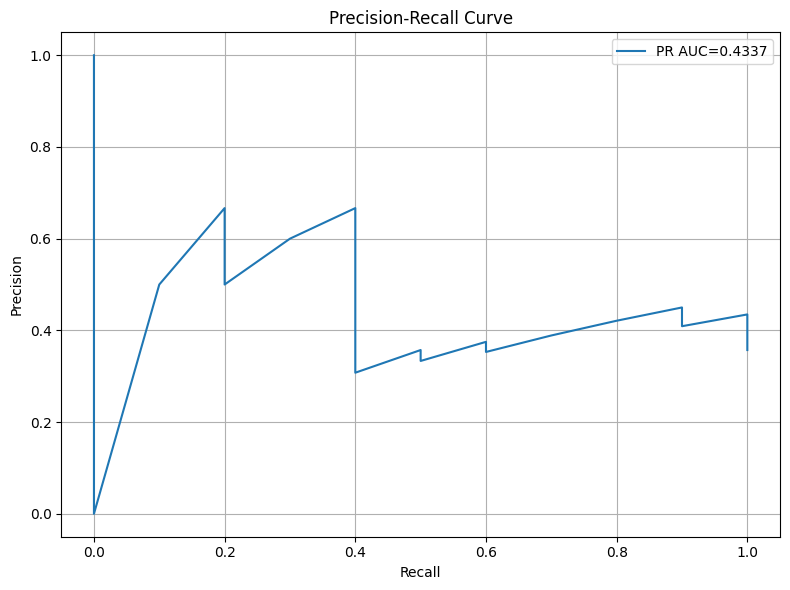

🎯 Best threshold: 0.10
✅ Accuracy: 0.5357, F1: 0.6061
✅ Confusion Matrix:
 [[ 5 13]
 [ 0 10]]
✅ Classification Report:
               precision    recall  f1-score   support

Non-Increase       1.00      0.28      0.43        18
    Increase       0.43      1.00      0.61        10

    accuracy                           0.54        28
   macro avg       0.72      0.64      0.52        28
weighted avg       0.80      0.54      0.50        28



<Artifact kobigbird-binary-sweep>

In [ ]:
import json
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    precision_recall_curve, classification_report, auc
)
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

# ✅ 설정
MODEL_NAME = "monologg/kobigbird-bert-base"
MAX_LEN = 4096
BATCH_SIZE = 4
EPOCHS = 10
LR = 2e-5
THRESHOLD_SWEEP = np.linspace(0.1, 0.9, 17)

# ✅ 데이터셋 정의
class DialogueBinaryDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = item["input_text"]
        label = 1.0 if float(item["label_female"]) > 0.5 else 0.0

        encoded = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        }

# ✅ 모델 정의
class KoBigBirdBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        hidden = self.encoder.config.hidden_size
        self.classifier = nn.Linear(hidden * 2, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]
        pooled = torch.max(outputs.last_hidden_state, dim=1).values
        combined = torch.cat([cls_emb, pooled], dim=-1)
        return self.classifier(combined).squeeze(-1)

# ✅ 데이터 로드
with open("dialogues_human.jsonl", "r", encoding="utf-8") as f:
    all_data = [json.loads(line) for line in f if line.strip()]

# ✅ Stratified Split
train_data, test_data = train_test_split(
    all_data,
    test_size=0.2,
    random_state=42,
    stratify=[1 if float(d["label_female"]) > 0.5 else 0 for d in all_data]
)

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = DialogueBinaryDataset(train_data, tokenizer)
test_dataset = DialogueBinaryDataset(test_data, tokenizer)

# ✅ Weighted Sampler
train_labels = [1 if float(d["label_female"]) > 0.5 else 0 for d in train_data]
class_counts = np.bincount(train_labels)
weights = 1. / class_counts
sample_weights = [weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ✅ 모델 설정
model = KoBigBirdBinaryClassifier().cuda()
pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).cuda()
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

wandb.init(project="huggingface", name="kobigbird-binary-sweep")
wandb.watch(model, log_freq=100)

# ✅ 학습
model.train()
for epoch in range(EPOCHS):
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["label"].cuda()

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({"train_loss": loss.item()})

# ✅ 평가
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["label"].cuda()

        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().long().numpy())

# ✅ Threshold Sweep
best_th, best_f1 = 0, 0
for th in THRESHOLD_SWEEP:
    preds = (np.array(all_probs) > th).astype(int)
    f1 = f1_score(all_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

# ✅ 최종 평가
final_preds = (np.array(all_probs) > best_th).astype(int)
acc = accuracy_score(all_labels, final_preds)
f1 = f1_score(all_labels, final_preds)
conf_mat = confusion_matrix(all_labels, final_preds)
report = classification_report(all_labels, final_preds, target_names=["Non-Increase", "Increase"])

# ✅ PR Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC={pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 출력
print(f"🎯 Best threshold: {best_th:.2f}")
print(f"✅ Accuracy: {acc:.4f}, F1: {f1:.4f}")
print("✅ Confusion Matrix:\n", conf_mat)
print("✅ Classification Report:\n", report)

wandb.log({"accuracy": acc, "f1": f1, "best_threshold": best_th})

# ✅ 저장
torch.save(model.state_dict(), "kobigbird_binary_sweep.pt")
artifact = wandb.Artifact("kobigbird-binary-sweep", type="model")
artifact.add_file("kobigbird_binary_sweep.pt")
wandb.log_artifact(artifact)
